# Detect one hand finger's number using Tensorflow and CNN

In this notebook, we will train a Convolutional Neural Network using Tensorflow to detect on an image which number is done using fingers. At the end of the notebook, we'll save the parameters in a $.npy$ format.

## Organization of this Notebook 
    1. Packages
    2. Load and prepare data set
    3. Tensorflow's required functions
    4. Save and load functions for the parameters
    5. Construct, train and save the model

## 1 - Packages ##

In [1]:
import numpy as np
import cv2 # Used for color conversion
import matplotlib.pyplot as plt
import tensorflow as tf
import os # Used to read, open and create files
from IPython.display import clear_output # Used at the end for the demo
from py_utils import load_dataset, random_mini_batches_CNN

%matplotlib inline

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 -  Load and prepare data set ##

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

### a. Images

Images of size: (64, 64, 3)


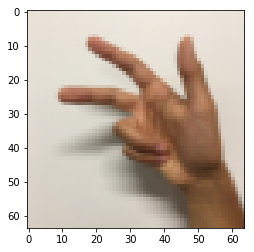

In [3]:
plt.imshow(X_train_orig[100])
print("Images of size: " + str(X_train_orig[100].shape))

In [4]:
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

print ("number of training examples = " + str(X_train_orig.shape[0]))
print ("number of test examples = " + str(X_test_orig.shape[0]))
print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))

number of training examples = 1080
number of test examples = 120
X_train_orig shape: (1080, 64, 64, 3)
X_test shape: (120, 64, 64, 3)


### b. Labels

Y_train_orig shape: (1, 1080)
Y_test_orig shape: (1, 120)


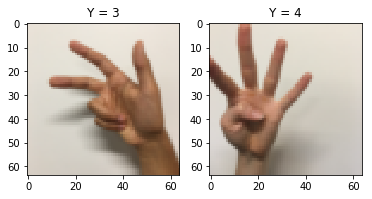

In [5]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_train_orig[100])
plt.title("Y = " + str(np.squeeze(Y_train_orig[:, 100])))
plt.subplot(1,2,2)
plt.imshow(X_test_orig[50])
plt.title("Y = " + str(np.squeeze(Y_test_orig[:, 50])))

print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("Y_test_orig shape: " + str(Y_test_orig.shape))

Currently, the labels contains a number between 0 and 5. We reshape the labels to fit the following:
<img src="images/hands.png">

In [6]:
def convertLabels(Y, size):
    Labels = np.eye(size)[Y.reshape(-1)]
    return Labels

In [7]:
Y_train = convertLabels(Y_train_orig, 6)
Y_test = convertLabels(Y_test_orig, 6)

Y_train shape: (1080, 6)
Y_test shape: (120, 6)


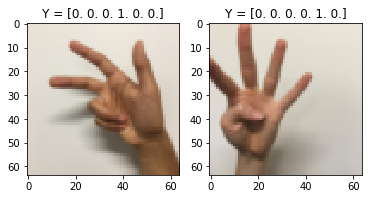

In [8]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_train_orig[100])
plt.title("Y = " + str(Y_train[100, :]))
plt.subplot(1,2,2)
plt.imshow(X_test_orig[50])
plt.title("Y = " + str(Y_test[50, :]))

print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

## 3 - Tensorflow's required functions ##

In [9]:
def initialize():
    parameter = {}
    
    parameter["W1"] = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer())
    parameter["W2"] = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer())
    
    return parameter

In [10]:
def forwardPropagation(X, parameters):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    # CONV2D: filters W1, stride 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = A1 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # FULLY-CONNECTED without non-linear activation function. 6 neurons in output layer.
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    return Z3

In [11]:
def computeCost(Z, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    
    return cost

In [12]:
def computeCostL2Reg(Z, Y, parameters, beta = 0.01):
    
    # Original loss function
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    
    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(parameters)
    
    return tf.reduce_mean(cost + beta * regularizer)

## 4 - Save and load functions for the parameters ##

In [13]:
def saveParameters(parameters, folderName = ""):
    if not os.path.exists("parametersCNN/"):
        os.mkdir("parametersCNN")
    
    path = "parametersCNN/" + folderName + "/"
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    for l in range(len(parameters)):
        np.save(path + 'W' + str(l+1), parameters['W' + str(l+1)])

In [14]:
def loadParameters(folderName = ""):
    parameters = {}
    path = "parametersCNN/" + folderName + "/"
    
    for entry in os.listdir(path):
        if os.path.isfile(os.path.join(path, entry)):
            if entry[-4:] == ".npy":
                parameters[entry[:-4]] = np.load(os.path.join(path, entry))
    
    return parameters

## 5 - Construct, train and save the models ##

In [15]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    (m, n_H, n_W, n_C) = X_train.shape
    n_y = Y_train.shape[1]
    
    costs = []
    
    tf.reset_default_graph()
    
    # Create tf Placeholders
    X = tf.placeholder(tf.float32, shape = [None, n_H, n_W, n_C])
    Y = tf.placeholder(tf.float32, shape = [None, n_y])

    parameters = initialize()
    
    # Build the forward propagation in the tensorflow graph
    Z = forwardPropagation(X, parameters)
    
    # Add cost function to tensorflow graph)
    cost = computeCost(Z, Y)
    
    # Define the tensorflow optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches_CNN(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost"
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost = epoch_cost + minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        predict_op = tf.argmax(Z, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 1.911004
Cost after epoch 5: 1.357729
Cost after epoch 10: 0.892746
Cost after epoch 15: 0.693593
Cost after epoch 20: 0.619131
Cost after epoch 25: 0.529206
Cost after epoch 30: 0.468032
Cost after epoch 35: 0.398948
Cost after epoch 40: 0.372404
Cost after epoch 45: 0.377992
Cost after epoch 50: 0.323718
Cost after epoch 55: 0.462005
Cost after epoch 60: 0.283659
Cost after epoch 65: 0.259416
Cost after epoch 70: 0.311813
Cost after epoch 75: 0.200636
Cost after epoch 80: 0.219903
Cost after epoch 85: 0.230660
Cost after epoch 90: 0.172129
Cost after epoch 95: 0.172473


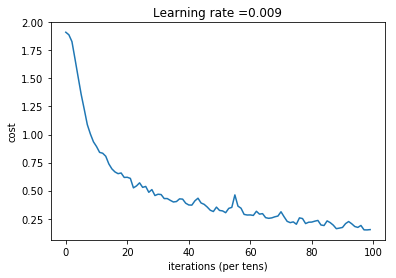

Parameters have been trained!
Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9638889
Test Accuracy: 0.8666667


In [16]:
parameters = model(X_train, Y_train, X_test, Y_test)

saveParameters(parameters, "RGB")

## 6 - Test the model ##

In [32]:
def predictTensorflow(X, parameters):
    
    print(X.shape)
    
    (m, n_H, n_W, n_C) = X.shape
    
    x = tf.placeholder(tf.float32, shape = [None, n_H, n_W, n_C])
    
    z = forwardPropagation(x, parameters)
    
    p = tf.argmax(z, 1)
 
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
    sess.close()
    
    return prediction

In [40]:
def demo(X, params):
    
    try:
        while(True):
            # Randomly select pictures
            index = np.random.randint(X.shape[0])
            
            img = np.array([X[index] / 255.])
            
            plt.title("Predicted:\n" + str(np.squeeze(predictTensorflow(img, params))))
            plt.imshow(X[index])
            plt.axis('off')

            plt.show()

            # Display the images until new ones are available
            clear_output(wait=True)
    except KeyboardInterrupt:
        print("Demo ended")

In [41]:
params = loadParameters("RGB")
demo(X_train_orig, params)

(1, 64, 64, 3)


FailedPreconditionError: Attempting to use uninitialized value fully_connected_9/biases
	 [[Node: fully_connected_9/biases/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fully_connected_9/biases)]]

Caused by op 'fully_connected_9/biases/read', defined at:
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-f2a6fd3f63df>", line 2, in <module>
    demo(X_train_orig, params)
  File "<ipython-input-40-8c644518a36d>", line 10, in demo
    plt.title("Predicted:\n" + str(np.squeeze(predictTensorflow(img, params))))
  File "<ipython-input-32-6058347f22f2>", line 9, in predictTensorflow
    z = forwardPropagation(x, parameters)
  File "<ipython-input-10-c4e302b1cffa>", line 24, in forwardPropagation
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1849, in fully_connected
    outputs = layer.apply(inputs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\base_layer.py", line 774, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\layers\base.py", line 329, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\base_layer.py", line 696, in __call__
    self.build(input_shapes)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\layers\core.py", line 899, in build
    trainable=True)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\base_layer.py", line 460, in add_variable
    return self.add_weight(*args, **kwargs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\layers\base.py", line 243, in add_weight
    getter=vs.get_variable)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\base_layer.py", line 534, in add_weight
    use_resource=use_resource)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\training\checkpointable\base.py", line 497, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 1328, in get_variable
    constraint=constraint)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 1090, in get_variable
    constraint=constraint)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 427, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1744, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1735, in _model_variable_getter
    use_resource=use_resource)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\framework\python\ops\variables.py", line 297, in model_variable
    use_resource=use_resource)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\framework\python\ops\variables.py", line 252, in variable
    use_resource=use_resource)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 404, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 796, in _get_single_variable
    use_resource=use_resource)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 2234, in variable
    use_resource=use_resource)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 2224, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variable_scope.py", line 2207, in default_variable_creator
    constraint=constraint)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variables.py", line 259, in __init__
    constraint=constraint)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\array_ops.py", line 79, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3887, in identity
    "Identity", input=input, name=name)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\DEJ6SI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value fully_connected_9/biases
	 [[Node: fully_connected_9/biases/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fully_connected_9/biases)]]
